## This does the comparison between fit function and GP fitting on 3.6fb-1 of data and injecting a Gaussian signal based on a fit to our q* samples

In [1]:
%pylab inline --no-import-all

/Users/MeghanFrate/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Populating the interactive namespace from numpy and matplotlib


In [2]:
import george
from george.kernels import MyDijetKernelSimp


import math
import time
import numpy as np
import scipy.stats as ss
import scipy.special as ssp
import scipy.optimize as op
from numpy.linalg import inv
from iminuit import Minuit

import ROOT as r
from rootpy.plotting import Hist, Hist2D, Legend, Canvas
import rootpy.plotting.root2matplotlib as rplt

In [3]:
runOnlyGP=False
runOnlyFF=False

### Load inputs

In [4]:
xvalO = np.load("newoutputs/xvalO.npy") 
yvalO = np.load("newoutputs/yvalO.npy")
xerrO = np.load("newoutputs/xerrO.npy")
xlowO = np.load("newoutputs/xlowO.npy")
xval = np.load("newoutputs/xval.npy")
yval = np.load("newoutputs/yval.npy")
xerr = np.load("newoutputs/xerr.npy")

xlowO = list(xlowO)
#toyList = np.load("newoutputs/toyList.npy")
lumiToyDict = np.load("newoutputs/lumiToyList.npy")

xvalO_ext = np.load("newoutputs/xvalO_ext.npy")
xerrO_ext = np.load("newoutputs/xerrO_ext.npy")
xlowO_ext = np.load("newoutputs/xlowO_ext.npy")
xlowO_ext = list(xlowO_ext)

yvalO_ext = np.concatenate((yvalO, np.zeros(xvalO_ext.size-xvalO.size)))


### 3 parameters fit function

In [5]:
def model_3param(t, params, xErr=xerr): 
    p0, p1, p2 = params
    sqrts = 13000.
    return (p0 * ((1.-t/sqrts)**p1) * (t/sqrts)**(p2))*(xErr) 


### Calculate z values and chi squared

In [6]:
def calcSignificance(Data, Bkg):
    pvals = []
    zvals = []
    chi2 = 0
    for i, nD in enumerate(Data):
        nB = Bkg[i]
        if nD != 0:
            if nB > nD:
                pval = 1.-ssp.gammainc(nD+1.,nB)
            else:
                pval = ssp.gammainc(nD,nB)
            prob = 1-2*pval
            if prob > -1 and prob < 1:
                zval = math.sqrt(2.)*ssp.erfinv(prob)
            else:
                zval = np.inf
            if zval > 100: zval = 20
            if zval < 0: zval = 0
            if (nD < nB): zval = -zval
        else: zval = 0
            
        zvals.append(zval)
        chi2 += ((nD - nB) ** 2 / abs(nB)) 
    return zvals, chi2

### Poisson log likelihood

In [7]:
def simpleLogPoisson(x, par):
    if x < 0: 
        return np.inf
    elif (x == 0): return -1.*par
    else:
        lnpoisson = x*np.log(par)-par-ssp.gammaln(x+1.)
        return lnpoisson

### remove zero count bins to use for GP fits

In [8]:
def removeZeros(data):
    indices = [i for i, x in enumerate(data) if x == 0]
    newylist=[]
    newxlist=[]
    newxerrlist=[]
    for k in range(len(data)):
        if k not in indices:
            newylist.append(data[k])
            newxlist.append(xvalO_ext[k])
            newxerrlist.append(xerrO_ext[k])
    return np.array(newylist), np.array(newxlist), np.array(newxerrlist)

In [9]:
def chi2_withCov(obs, exp, var):
    diff = (np.array(obs)-np.array(exp))
    V = inv(var)
    diffT = np.transpose(diff)
    return np.dot(np.dot(diffT, V), diff)

In [10]:
def sig_model(x, N=1e5, mass=2000., width=100., xErr=xerr):
    return N*(np.exp(-(x-mass)**2/2/width/width)/np.sqrt(2*np.pi)/width)*xErr

### fit for noncentrality parameter of non central chi-squared

In [11]:
def ncchi(x, nc, amp): 
    return amp*ss.ncx2.pdf(x, 1., nc)

### plot distribution of chi-squared from fits to toys

In [12]:
def makePrettyPlots_chi2(GPchi2, BKGchi2, title, drawchi2=False, xname=r'$\chi^{2}$', label1 = "Gaussian Process", label2 = "Fit Function"):
    f, (ax1, ax2) = plt.subplots(2, figsize=(12,12), gridspec_kw = {'height_ratios':[1, 1]})
    f.suptitle(title, fontsize=40)

    lowx = min(min(GPchi2), min(BKGchi2))
    highx = max(max(GPchi2), max(BKGchi2))
    bins = np.linspace(lowx, highx, 200)
    dx = bins[1]-bins[0]
    bin_centers = bins[:-1] + dx/2.

    hGP, _, _ =ax1.hist(GPchi2, bins=bins, color="b")
    ax1.tick_params(axis='y', labelsize=30)
    ax1.tick_params(axis='x', labelsize=30)
    ax1.set_title(label1, fontsize=30)
    
    if drawchi2:
        bf_params, bf_cov = op.curve_fit(ncchi, bin_centers, hGP)
        print "nc, amp ", bf_params
        chiPDF = bf_params[1]*ss.ncx2.pdf(bin_centers, 1., bf_params[0])
        ax1.plot(bin_centers, chiPDF, c='r', linewidth=2)
    
    
    hBKG, _, _ =ax2.hist(BKGchi2, bins=bins, color='g')
    ax2.tick_params(axis='y', labelsize=30)
    ax2.tick_params(axis='x', labelsize=30)
    ax2.set_xlabel(xname, fontsize=40)
    ax2.set_title(label2, fontsize=30)
    if drawchi2:
        bf_params, bf_cov = op.curve_fit(ncchi, bin_centers, hBKG)
        print "nc, amp ", bf_params
        chiPDF = bf_params[1]*ss.ncx2.pdf(bin_centers, 1., bf_params[0])
        ax2.plot(bin_centers, chiPDF, c='r', linewidth=2)
    
    plt.show()



### Plot average chi squared of fit to toys

In [13]:
def makePrettyPlots_chi2Lumi(lumis, GPchi2, BKGchi2, GPchi2var, BKGchi2var, title):
    f, (ax1) = plt.subplots(1, figsize=(12,12), gridspec_kw = {'height_ratios':[1, 1]})
    f.suptitle(title, fontsize=40)
    gpPlot = ax1.errorbar(lumis, GPchi2, marker='o', ls='None', yerr = GPchi2var, c='green',  markersize=10, label="Gaussian Process model")
    bkgPlot = ax1.errorbar(lumis, BKGchi2, marker='o', ls='None', yerr = BKGchi2var, c='blue',  markersize=10, label="ad-hoc fit")

    
    ax1.legend(loc="upper left", prop={'size':20})
    ax1.tick_params(axis='y', labelsize=30)
    ax1.tick_params(axis='x', labelsize=30)
    ax1.set_xlabel(r'Toy Data Integrated Luminosity $\mathregular{fb^{-1}}$', fontsize=40)
    ax1.set_ylabel(r'$\chi^{2}$/d.o.f', fontsize=40)
    ax1.set_xlim([0, 105])
 
    plt.show()

In [14]:
def makePrettyPlots(xs, ys, bkgs, title, col = 'g', ymax = 2e5):
    f, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(12,12), gridspec_kw = {'height_ratios':[3, 1]})
    f.suptitle(title, fontsize=30)
    dataPlot = ax1.errorbar(xs, ys, marker='o', ls='None', yerr = np.sqrt(ys), c='black', markersize=10, label="data+signal")
    bkgPlot, =ax1.plot(xs, bkgs, color=col, linewidth=3.0, label="bkg only")
    ax1.legend()
    ax1.set_ylabel('Events', fontsize=20)
    ax1.tick_params(axis='y', labelsize=20)
    ax1.set_yscale('log', nonposy="clip")
    ax1.set_xscale('log')
    ax1.set_xlim([1000, 9500])
    ax1.set_ylim([0.1, ymax])
  
    #bin by bin significance    
    zvals, chi2 = calcSignificance(ys, bkgs)
    print "chi2", chi2
    h1 = Hist(xlowO_ext,markersize=0)
    for x in range(len(zvals)):
        if zvals[x] == np.inf or zvals[x] == -np.inf: h1[x] = 20
        else: h1[x] = zvals[x]  

    h1.fillstyle = 'solid'
    if col == 'g':
         h1.fillcolor = 'green'
    elif col == 'b':
         h1.fillcolor = 'blue'
    elif col == 'r':
         h1.fillcolor = 'red'
    else:
        h1.fillcolor = 'black'
    h1.linecolor = 'black'
    h1.linewidth = 1
    h1.Draw("histX0")
    rplt.bar(h1, xerr=None, yerr=None)
    ax2.axhline(0, color='black', lw=1)
    ax2.tick_params(axis='x', labelsize=20)
    ax2.tick_params(axis='y', labelsize=20)
    ax2.set_xlabel(r"$m_{jj}$ [TeV]", fontsize=30)
    ax2.set_ylabel('Significance', fontsize=20)
    ax2.set_xscale('log')
    ax2.set_xlim([1000, 9500])
    ax2.set_xticks([1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000])
    ax2.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    minor_ticks = np.arange(1000, 9500, 100)
    ax2.set_xticks(minor_ticks, minor=True)  
    labels = ["1","2","3","4","5","6","7", "8","9"]
    ax2.set_xticklabels(labels)
    ax2.set_ylim([-5, 5])
    
    f.subplots_adjust(hspace=0)
    plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)    
    plt.show()




### Poisson likelihood for 3 parameter fit functions. Minuit minimization of 3 parameter fit function. minimize negative log likelihood, return minimum negative log likelihood and fit parameters corresponding to minimum.

In [15]:
class logLike_3ff:
    def __init__(self, x, y, xe):
        self.x = x
        self.y = y
        self.xe = xe
    def __call__(self, p0, p1, p2):
        params = p0, p1, p2
        bkgFunc = model_3param(self.x, params, self.xe)       
        logL = 0
        for ibin in range(len(self.y)):
            data = self.y[ibin]
            bkg = bkgFunc[ibin]
            logL += -simpleLogPoisson(data, bkg)
        try:
            logL
            return logL
        except:
            return np.inf
    

    
def fit_3ff(lnprob, Print = True):
    minLLH = np.inf
    best_fit_params = (0., 0., 0.)
    passedFit = False
    numRetries = 0
    while not passedFit and numRetries < 5:
        init0 = np.random.random() * 1.
        init1 = np.random.random() * 8.
        init2 = np.random.random() * 6.
        m = Minuit(lnprob, throw_nan = False, pedantic = False, print_level = 0, errordef=0.5,
                  p0 = init0, p1 = init1, p2 = init2,
                  error_p0 = 1e-2, error_p1 = 1e-2, error_p2 = 1e-2, 
                  limit_p0 = (0, 100.), limit_p1 = (-100., 100.), limit_p2 = (-100., 100.))
        fit = m.migrad()
        if fit[0]['is_valid']: 
            if numRetries == 4: print "retry number = ", numRetries+1
            passedFit=True
        numRetries+=1
        if m.fval < minLLH:
            minLLH = m.fval
            best_fit_params = m.args 
    if Print:
        print "min LL",minLLH
        print "best fit vals", best_fit_params

    return minLLH, best_fit_params



### mean function for GP - 3 parameter fit function. negative log likelihood for Gaussian Process - from george. Minuit minimzation for GP negative log likelihood. Return minimum log likelihood and hyperparameters and mean parameters corresponding to this minimum.

In [16]:
def model_gp(params, t, xerr=xerr): 
    p0, p1, p2 = params
    sqrts = 13000.
    return (p0 * (1.-t/sqrts)**p1 * (t/sqrts)**(p2))*xerr

class logLike_gp:
    def __init__(self, x, y, xerr):
        self.x = x
        self.y = y
        self.xerr = xerr
    def __call__(self, Amp, decay, length, power, sub, p0, p1, p2):
        kernel = Amp * MyDijetKernelSimp(a = decay, b = length, c = power, d = sub)
        gp = george.GP(kernel)
        try:
            gp.compute(self.x, np.sqrt(self.y))
            return -gp.lnlikelihood(self.y - model_gp((p0,p1,p2), self.x, self.xerr))
        except:
            return np.inf

def fit_gp_minuit(lnprob, Print = True):
    minLLH = np.inf
    best_fit_params = (0, 0, 0, 0, 0, 0, 0, 0)
    passedFit = False
    numRetries = 0
    while not passedFit and numRetries < 5:
        init0 = np.random.random() * 1e6+1
        init1 = np.random.random() * 400.
        init2 = np.random.random() * 10. 
        init3 = np.random.random() * -100.
        init4 = np.random.random() * 650.
        init5 = np.random.random() * 1.
        init6 = np.random.random() * 1.
        init7 = np.random.random() * -1.
        m = Minuit(lnprob, throw_nan = False, pedantic = False, print_level = 0, errordef=0.5,
                  Amp = init0, decay = init1, length = init2, power = init3, sub = init4, 
                   p0 = init5, p1 = init6, p2 = init7,
                  error_Amp = 1., error_decay = 0.1, error_length = 0.1, error_power = 0.1, 
                   error_sub = 0.1, error_p0 = 1e-2, error_p1 = 1e-2, error_p2 = 1e-2,
                  limit_Amp = (100., 1e15), limit_decay = (1, 3000), limit_length = (0.1, 1000), 
                   limit_power = (10, 3000), limit_sub = (200, 2000), limit_p0 = (0,1000), 
                   limit_p1 = (0, 100), limit_p2 = (-100,100)) 

        fit = m.migrad()
        if fit[0]['is_valid']: 
            passedFit=True
        if m.fval < minLLH:
            minLLH = m.fval
            best_fit_params = m.args 
        if numRetries == 4: 
            print "retry number = ", 5, ": failed fits"
            minLLH=np.inf
            best_fit_params=(0, 0, 0, 0, 0, 0, 0, 0)
        numRetries+=1

    if Print:
        print "min LL", minLLH
        print "best fit vals",best_fit_params
    return minLLH, best_fit_params

### Loop over luminosities and fit 3 parameter function and GP to toys. Refit for all hyperparameters and mean function parameters every time

In [17]:
def makePrettyPlots_oneBkgFits(xs, bkgFits, title, c='b', ymax = 2e5):
    f, ax1 = plt.subplots(1, sharex=True, figsize=(12,12))
    f.suptitle(title, fontsize=30)
    for iFit, bkg in enumerate(bkgFits): 
        bkgPlot, =ax1.plot(xs, bkg, color=c, alpha=0.3, linewidth=1.0)

    ax1.legend()
    ax1.set_ylabel('Events', fontsize=20)
    ax1.tick_params(axis='y', labelsize=20)
    ax1.set_yscale('log', nonposy="clip")
    ax1.set_xscale('log')
    ax1.set_xlim([1000, 7500])
    ax1.set_ylim([0.01, ymax])


    ax1.tick_params(axis='x', labelsize=20)
    ax1.tick_params(axis='y', labelsize=20)
    ax1.set_xlabel(r"$m_{jj}$ [TeV]", fontsize=30)

    ax1.set_xlim([1000, 7500])
    ax1.set_xticks([1000, 2000, 3000, 4000, 5000, 6000, 7000])
    ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    minor_ticks = np.arange(1000, 7500, 100)
    ax1.set_xticks(minor_ticks, minor=True)  
    labels = ["1","2","3","4","5","6","7"]
    ax1.set_xticklabels(labels)
    
    f.subplots_adjust(hspace=0)
    plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)    
    plt.show()


In [18]:
btime = time.time()
lumiList = [1.,3.,5.,10.,15.0, 20.0, 25., 30., 35., 40., 45., 50., 60., 70., 80., 90., 100.]


GPchi2list={}
FFchi2list={}

for lum in lumiList:
    print "lumi", lum
    toyList = lumiToyDict[()][lum]

    GPchi2list[lum]=[]
    FFchi2list[lum]=[]
    failedit=False
    madePlot=False
    for itoy, toy in enumerate(toyList[:10]):
        if failedit: 
            print "continuing"
            failedit=False
        if not itoy%100:
            print "toy: ", itoy
        
        ###find the last bin with data, cut off the rest of the distribution
        indx=-1
        for it, t in reversed(list(enumerate(toy))):
            if t!=0: 
                indx=it
                break
        
        if runOnlyGP: pass
        else:
            lnProb = logLike_3ff(xvalO_ext[:indx],toy[:indx],xerrO_ext[:indx])
            minimumLLHff, best_fit_ff = fit_3ff(lnProb, False)
            if np.isinf(minimumLLHff): 
                failedit = True
                continue
            ff = model_3param(xvalO_ext[:indx], best_fit_ff, xerrO_ext[:indx])
            zvalsff, chi2ff = calcSignificance(toy[:indx], ff)
       
            if not itoy%99:
                print "ff: ", best_fit_ff
            
            FFchi2list[lum].append(chi2ff/(len(xvalO_ext[:indx])-1-3))
                
        #########################################################        
        if runOnlyFF: pass
        else:
            ytoy, xtoy, xtoyerr = removeZeros(toy[:indx])  
            lnProb = logLike_gp(xtoy,ytoy,xtoyerr)
            minimumLLHgp, best_fit_gp = fit_gp_minuit(lnProb, False)
            if np.isinf(minimumLLHgp): 
                failedit = True
                continue
            Amp, decay, length, power, sub, p0, p1, p2 = best_fit_gp
            kernel = Amp * MyDijetKernelSimp(a = decay, b = length, c = power, d=sub)
            gp = george.GP(kernel)
            gp.compute(xtoy, np.sqrt(ytoy))
        
            try:
                gp.predict(ytoy - model_gp((p0,p1,p2),xtoy, xtoyerr), xvalO_ext)
            except:
                failedit=True
                print "failed"
                continue

            
            MAP, covGP = gp.predict(ytoy - model_gp((p0,p1,p2),xtoy, xtoyerr), xvalO_ext[:indx])
            MAP = MAP + model_gp((p0,p1,p2),xvalO_ext[:indx], xerrO_ext[:indx])
            zvalsgp, chi2gp = calcSignificance(toy[:indx], MAP)

            GPchi2list[lum].append(chi2gp/(len(toy[:indx])-1-8))


etime = time.time()
print "took "+str((etime-btime)/(60.*60.)) + "hours"
print "done with toys, making plot"


lumi 1.0
toy:  0
ff:  (0.0013306620292974358, 8.65859140345546, -5.212482292710618)
retry number =  5 : failed fits
continuing
retry number =  5 : failed fits
continuing
lumi 3.0
toy:  0
ff:  (0.0037136186703867757, 8.453871314403543, -5.2378511000283225)
lumi 5.0
toy:  0
ff:  (0.006452902217968237, 8.627311266015681, -5.226967709217135)
lumi 10.0
toy:  0
ff:  (0.013068058264992244, 8.591649346216144, -5.220541212851799)
lumi 15.0
toy:  0
ff:  (0.02035620371745317, 8.693919310890053, -5.2088752211784595)
lumi 20.0
toy:  0
ff:  (0.022367196833106284, 8.22129259136372, -5.272053463995007)
lumi 25.0
toy:  0
ff:  (0.030105042791594983, 8.389736652724196, -5.2468376335591245)
lumi 30.0
toy:  0
ff:  (0.03608844335986072, 8.400840203284574, -5.248239537080693)
lumi 35.0
toy:  0
ff:  (0.045236531576597905, 8.60031281974068, -5.225434525448364)
lumi 40.0
toy:  0
ff:  (0.04479870886252013, 8.25996632228285, -5.272287111151314)
lumi 45.0
toy:  0
ff:  (0.057693261015734354, 8.572360883881586, -5.2

### Plot average chi squared from fit to toys

done with toys, making plot
LUMI 1.0


/Users/MeghanFrate/anaconda2/lib/python2.7/site-packages/IPython/core/formatters.py:92: DeprecationWarning: DisplayFormatter._ipython_display_formatter_default is deprecated: use @default decorator instead.
  def _ipython_display_formatter_default(self):
/Users/MeghanFrate/anaconda2/lib/python2.7/site-packages/IPython/core/formatters.py:669: DeprecationWarning: PlainTextFormatter._singleton_printers_default is deprecated: use @default decorator instead.
  def _singleton_printers_default(self):


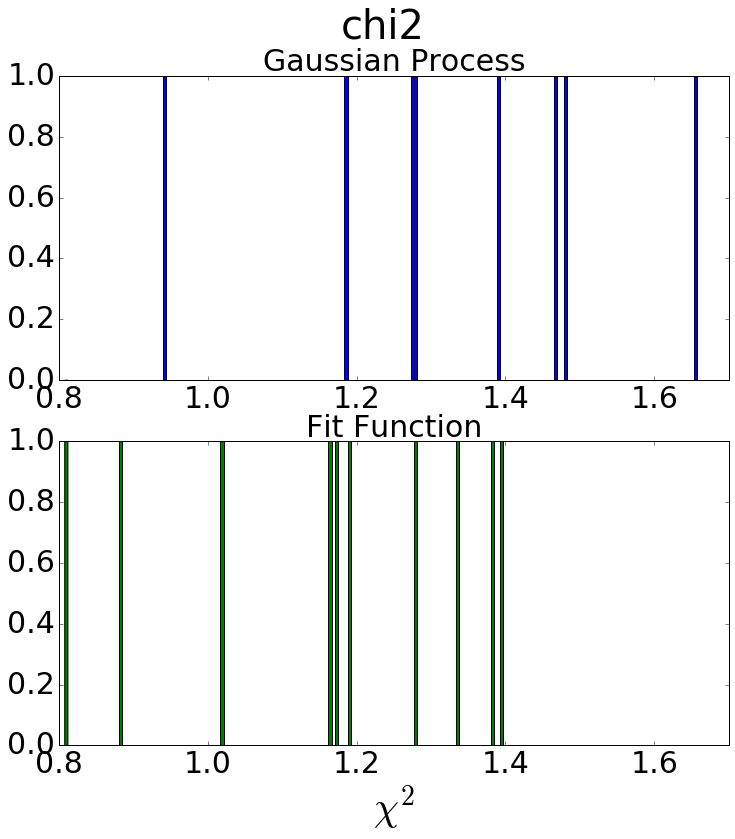

GP avg 1.33554857894 0.202654986271
FF avg 1.16287183569 0.192667925412
LUMI 3.0


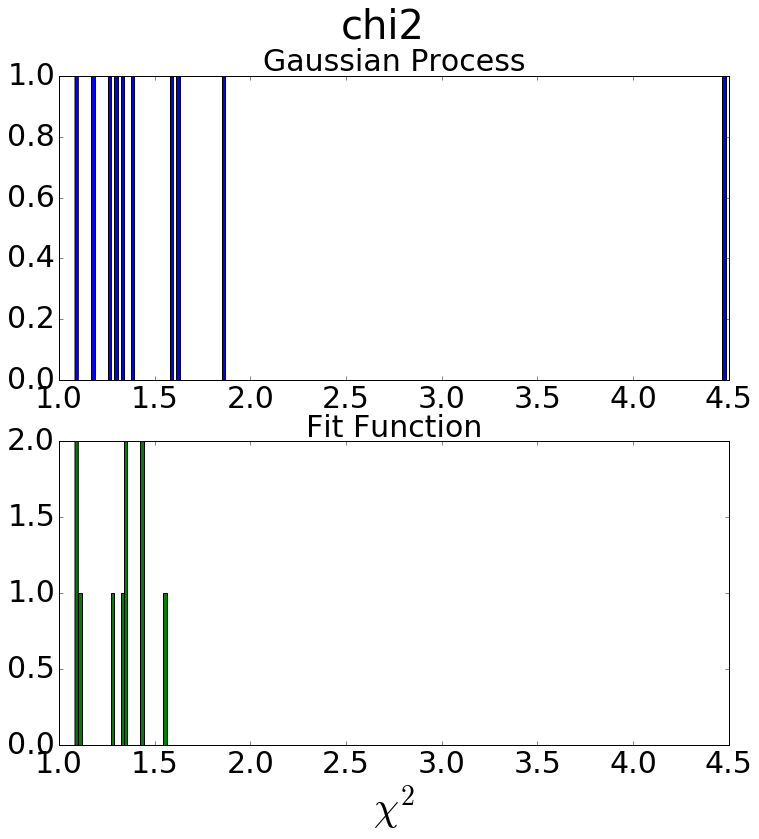

GP avg 1.70855822477 0.950574009362
FF avg 1.30044225408 0.151386403763
LUMI 5.0


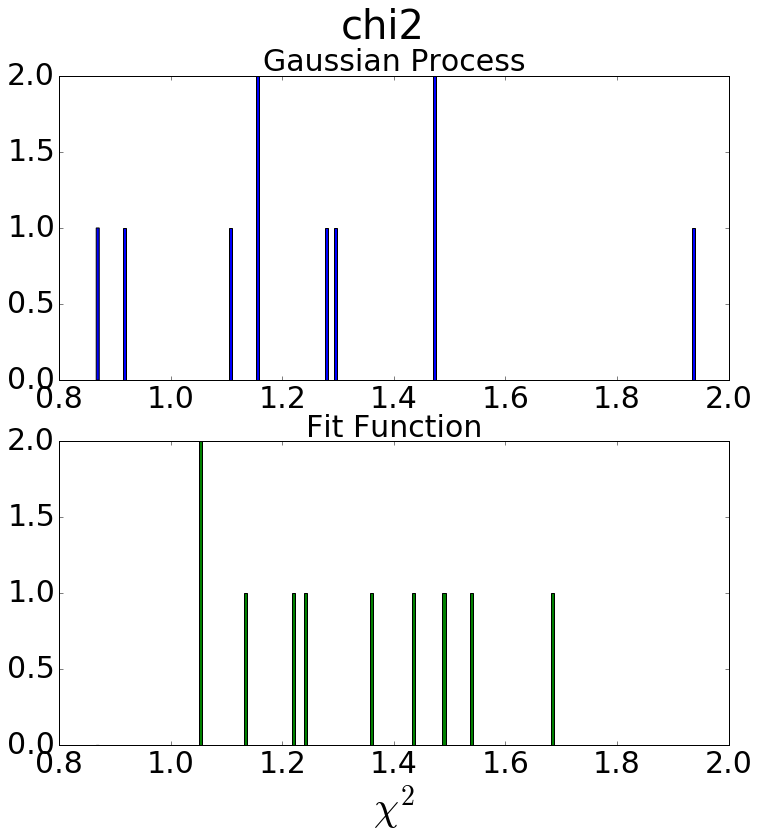

GP avg 1.26575437504 0.295543217107
FF avg 1.32101397467 0.204438388419
LUMI 10.0


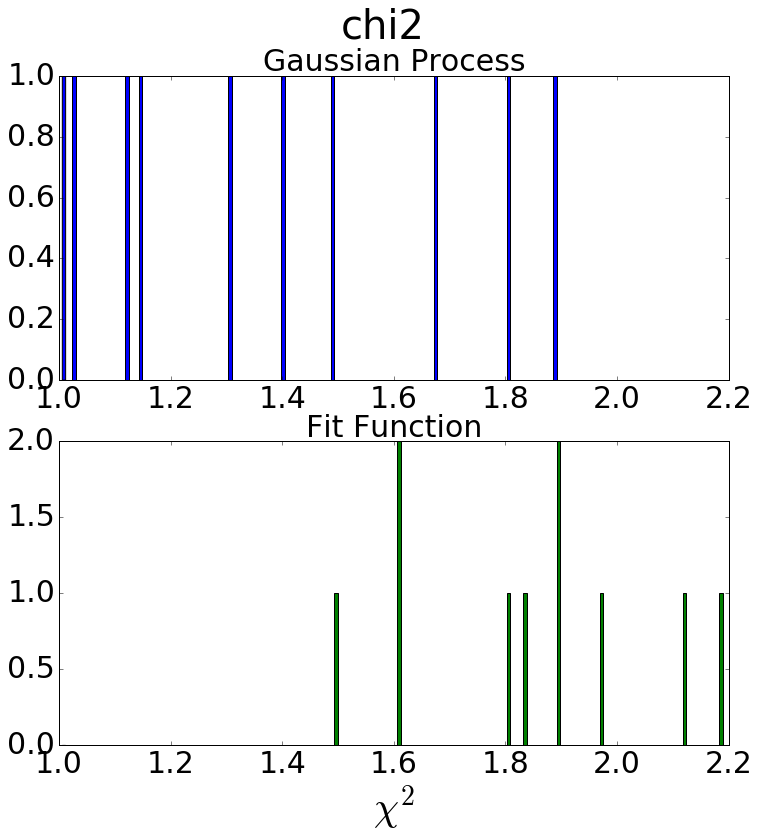

GP avg 1.38632515099 0.30476002163
FF avg 1.84350382099 0.21223637083
LUMI 15.0


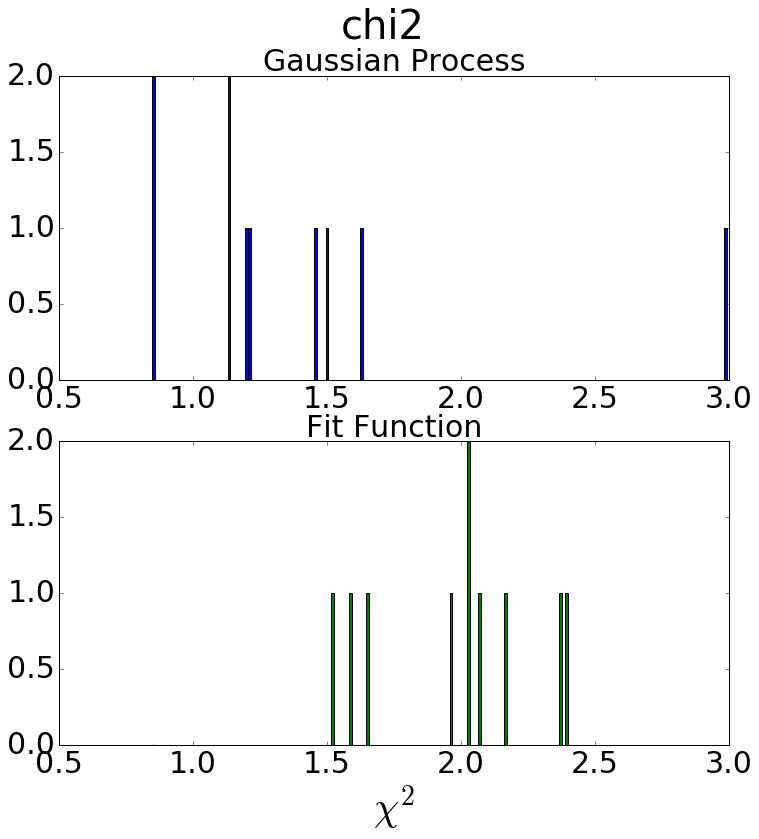

GP avg 1.3960415758 0.585550333202
FF avg 1.97838681641 0.292025600845
LUMI 20.0


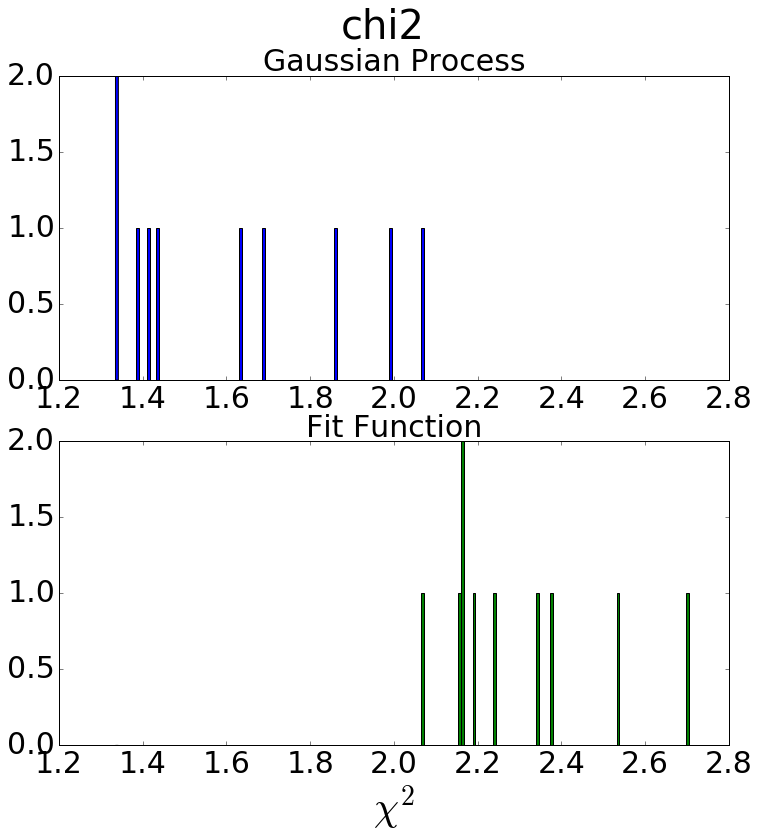

GP avg 1.61482026604 0.2640078053
FF avg 2.29502038107 0.187777665356
LUMI 25.0


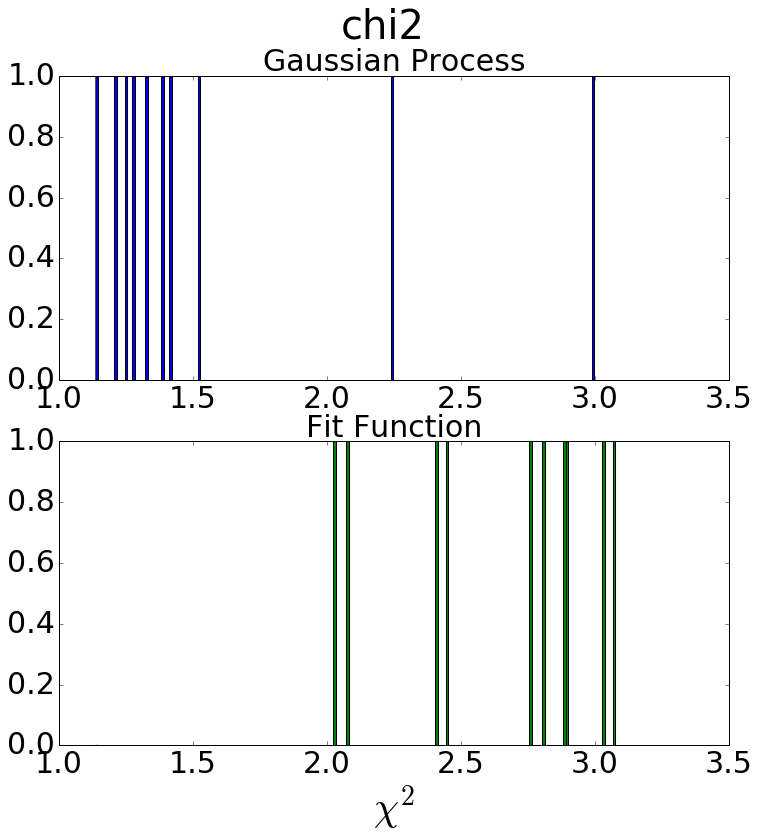

GP avg 1.57598593579 0.557008938727
FF avg 2.6420812268 0.360109152846
LUMI 30.0


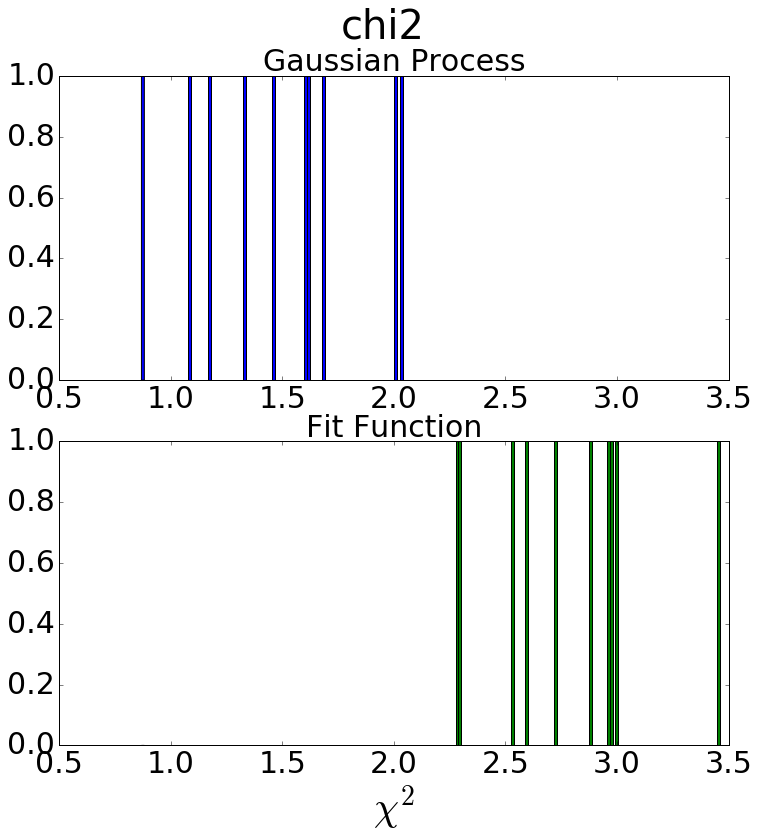

GP avg 1.48845252412 0.36201882839
FF avg 2.77205548419 0.34238697162
LUMI 35.0


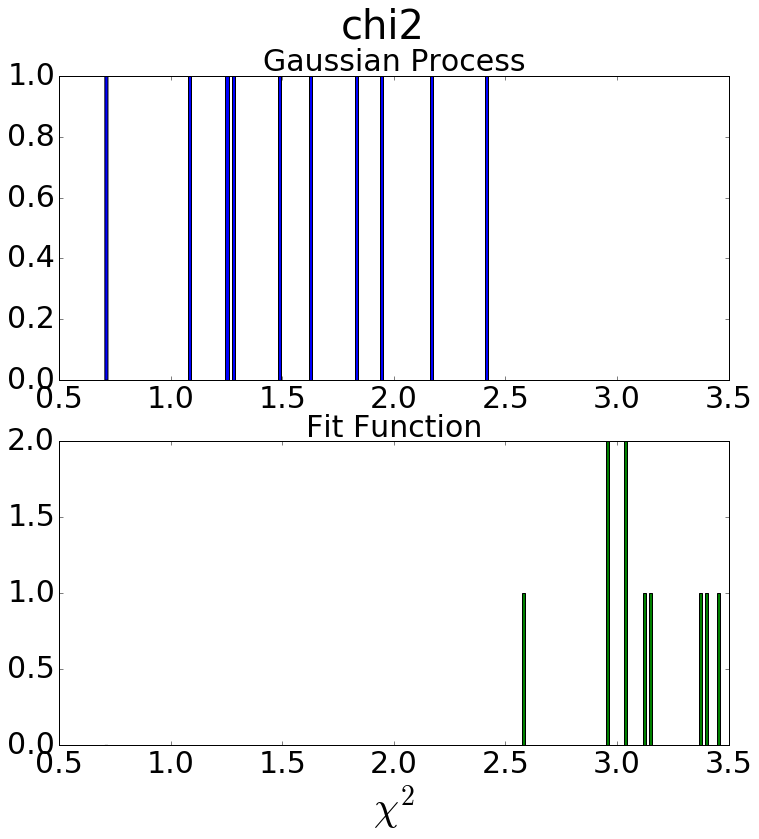

GP avg 1.57798701755 0.495070080967
FF avg 3.10777206649 0.249014845734
LUMI 40.0


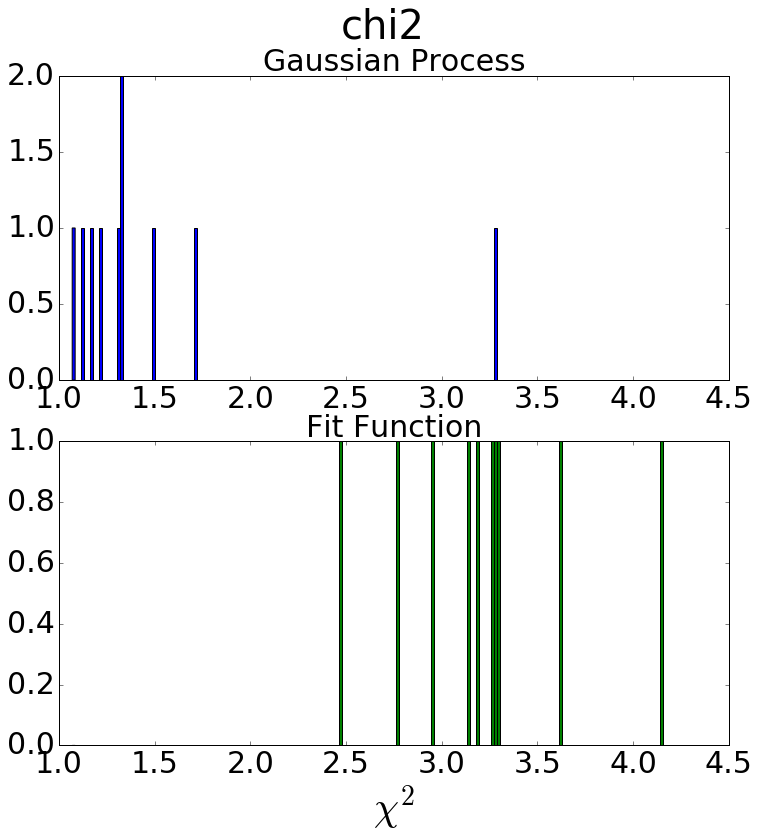

GP avg 1.50322630723 0.621006281362
FF avg 3.21432364008 0.433155717899
LUMI 45.0


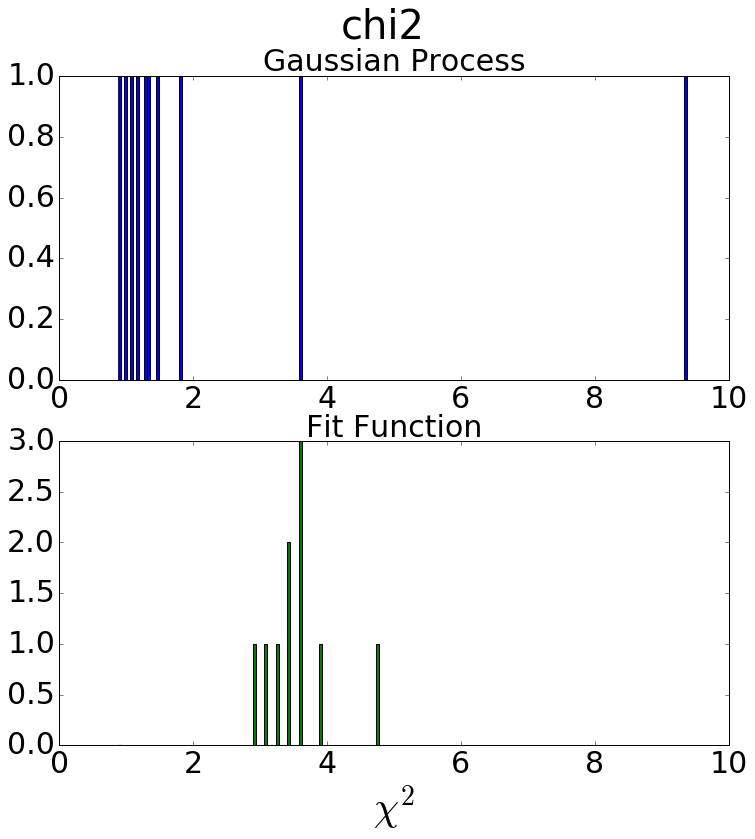

GP avg 2.30137189969 2.47463514829
FF avg 3.55786772758 0.478031650752
LUMI 50.0


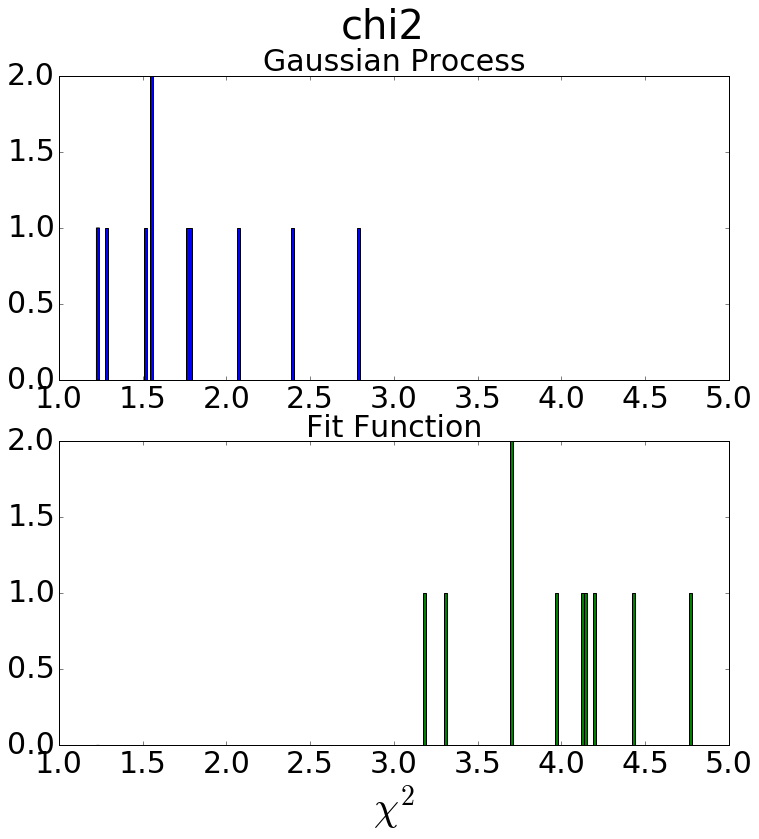

GP avg 1.79189613065 0.467700705037
FF avg 3.95679008839 0.468272643379
LUMI 60.0


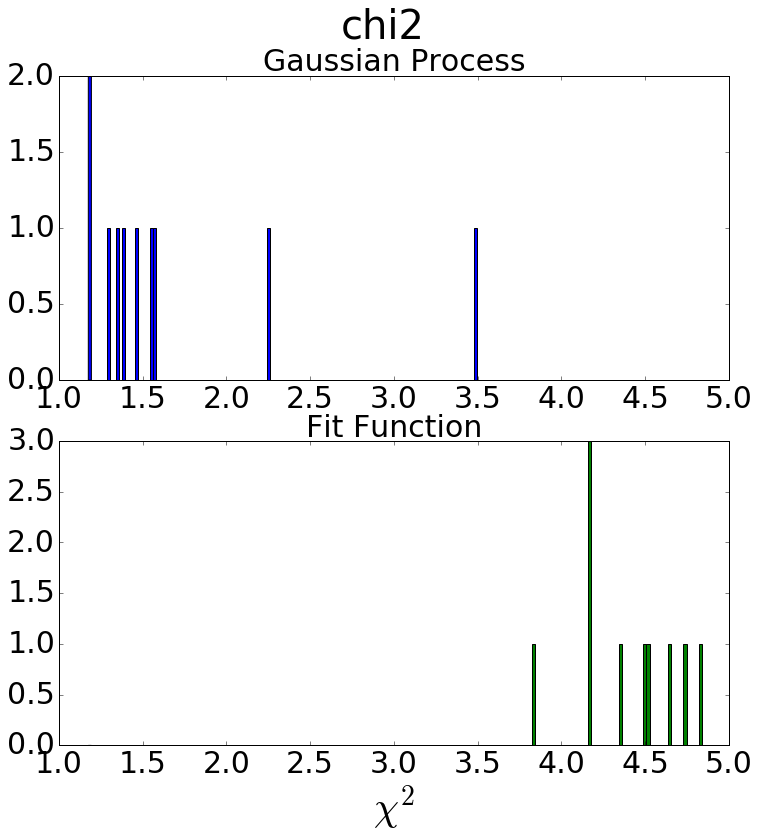

GP avg 1.66918606615 0.670602018082
FF avg 4.39435561279 0.297181447902
LUMI 70.0


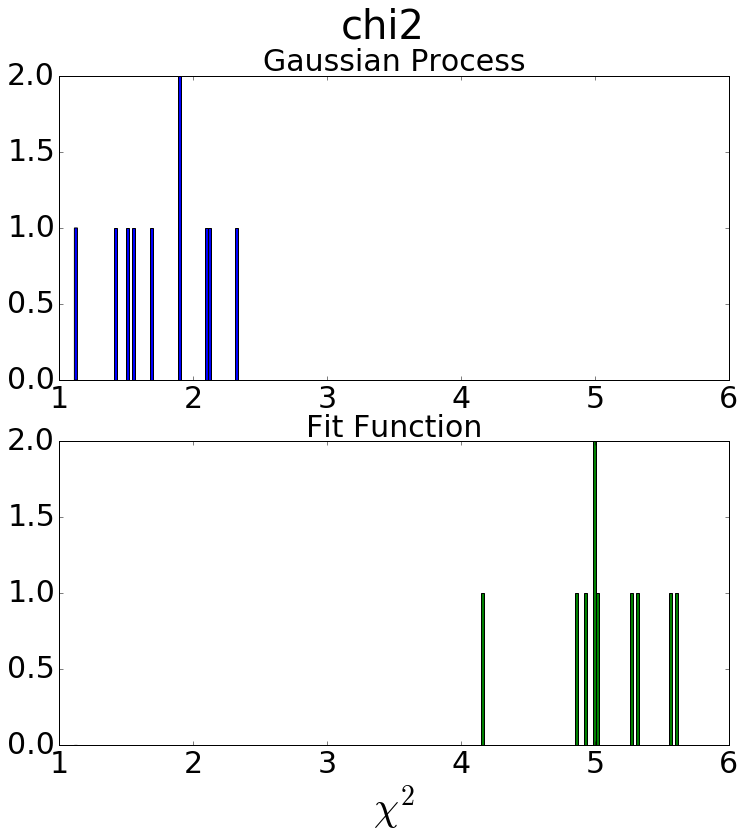

GP avg 1.7634203849 0.350629292086
FF avg 5.07535195301 0.393840102215
LUMI 80.0


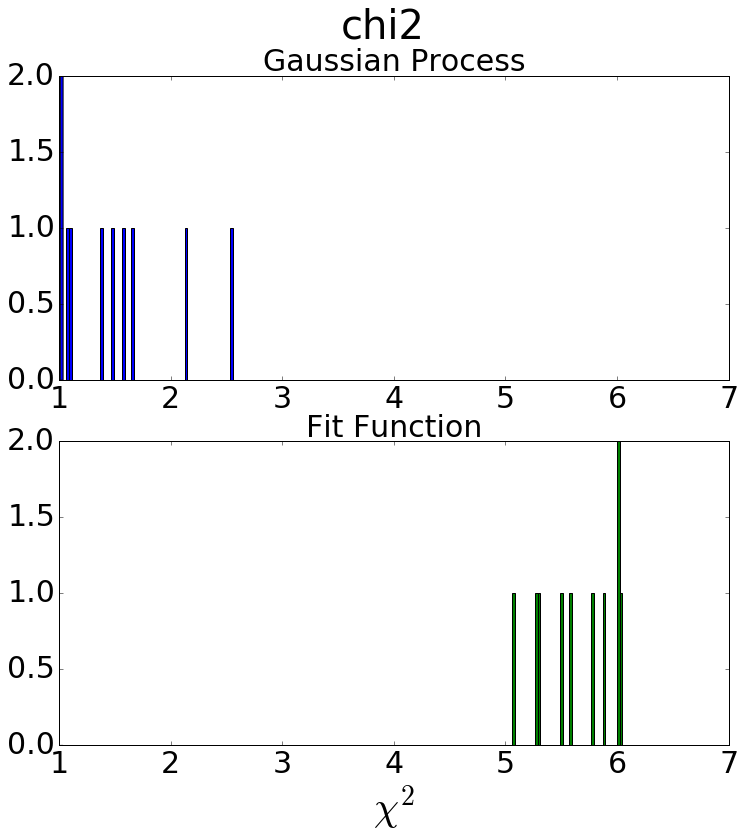

GP avg 1.49691619632 0.485886178869
FF avg 5.64401466423 0.333372214725
LUMI 90.0


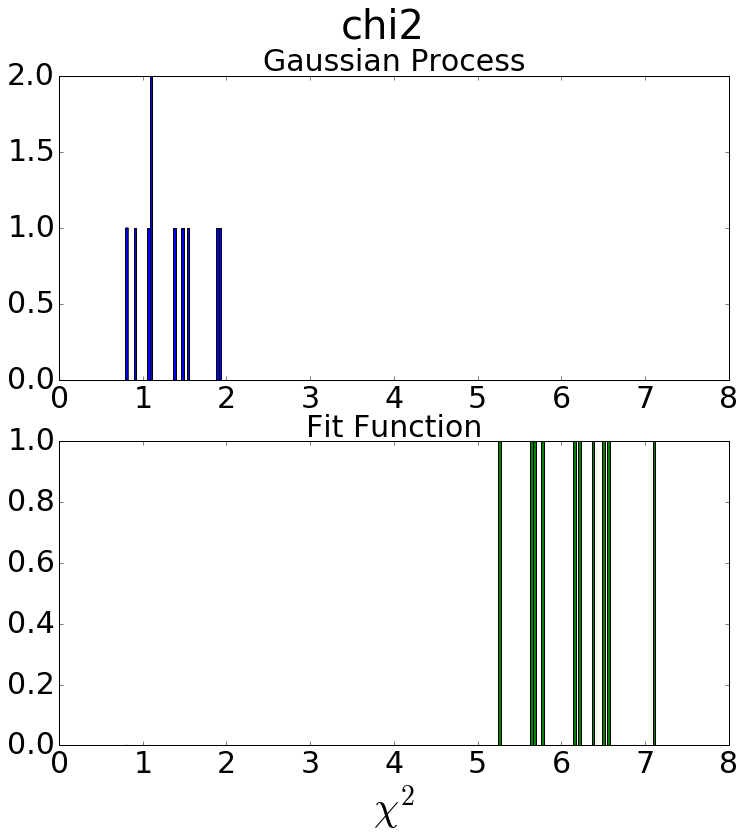

GP avg 1.31495430458 0.371455655336
FF avg 6.13024820327 0.523579093236
LUMI 100.0


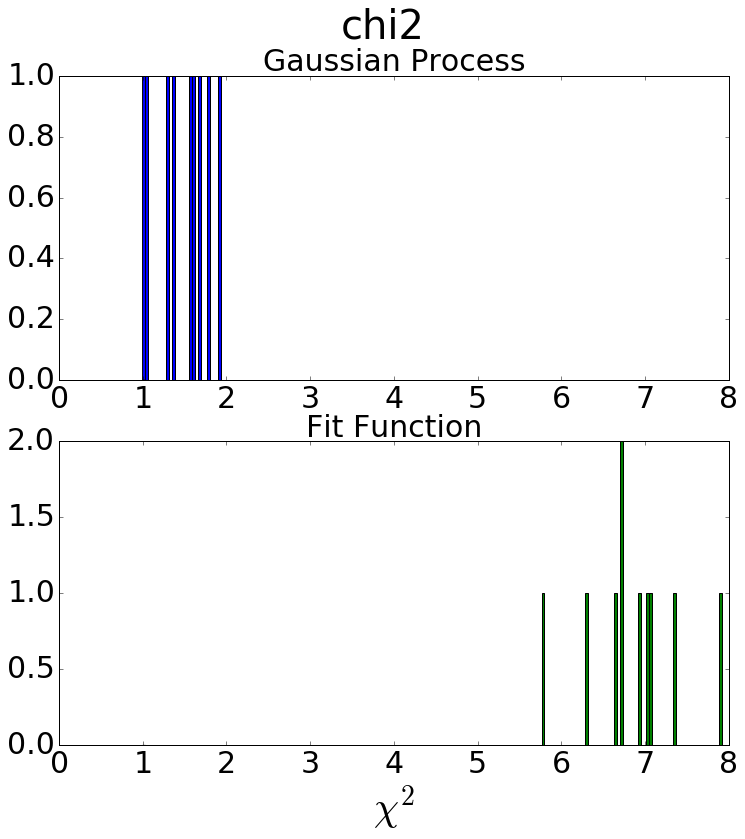

GP avg 1.47048227126 0.302356061977
FF avg 6.85289707668 0.550048385478


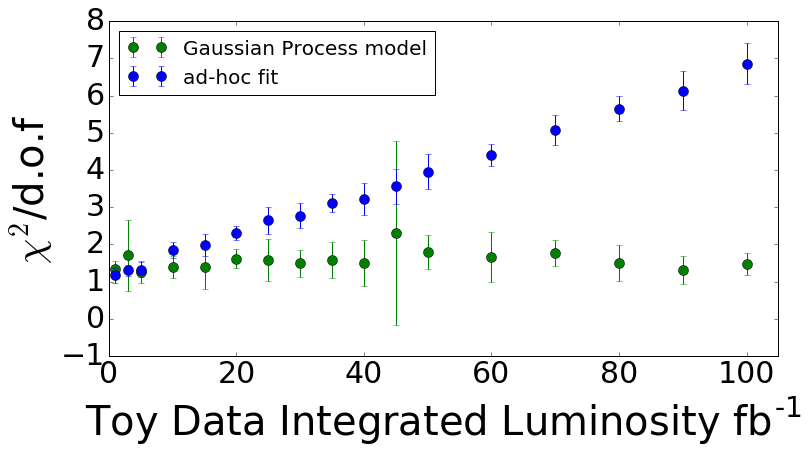

In [19]:
print "done with toys, making plot"
label = ""#"lumi vs chi2"
lumiList =  [1.,3.,5.0, 10.0, 15.0, 20.0, 25., 30., 35., 40.,45., 50.,60., 70., 80., 90., 100.]
GPchi2avList=[]
FFchi2avList=[]
for lum in lumiList:
    print "LUMI", lum
    chi2GPList = [s for s in np.array(GPchi2list[lum]) if s < 10] 
    chi2FFList = [s for s in np.array(FFchi2list[lum]) if s < 10] 
    
    makePrettyPlots_chi2(chi2GPList, chi2FFList, "chi2", drawchi2=False, xname=r'$\chi^{2}$', label1 = "Gaussian Process", label2 = "Fit Function")
    
    print "GP avg", np.mean(np.array(chi2GPList)), np.std(np.array(chi2GPList))
    print "FF avg", np.mean(np.array(chi2FFList)), np.std(np.array(chi2FFList))
    GPchi2avList.append([np.mean(np.array(chi2GPList)), np.std(np.array(chi2GPList))])
    FFchi2avList.append([np.mean(np.array(chi2FFList)), np.std(np.array(chi2FFList))])
makePrettyPlots_chi2Lumi(lumiList, [GPchi2avList[i][0] for i in range(len(lumiList))], [FFchi2avList[i][0] for i in range(len(lumiList))], [GPchi2avList[i][1] for i in range(len(lumiList))], [FFchi2avList[i][1] for i in range(len(lumiList))], label)

In [20]:
#np.save("newoutputs/GPchi2_MeanStd_Lumi.npy", GPchi2avList) 
#np.save("newoutputs/FFchi2_MeanStd_Lumi.npy", FFchi2avList)
GPchi2avList = np.load("newoutputs/GPchi2_MeanStd_Lumi.npy")
FFchi2avList = np.load("newoutputs/FFchi2_MeanStd_Lumi.npy")

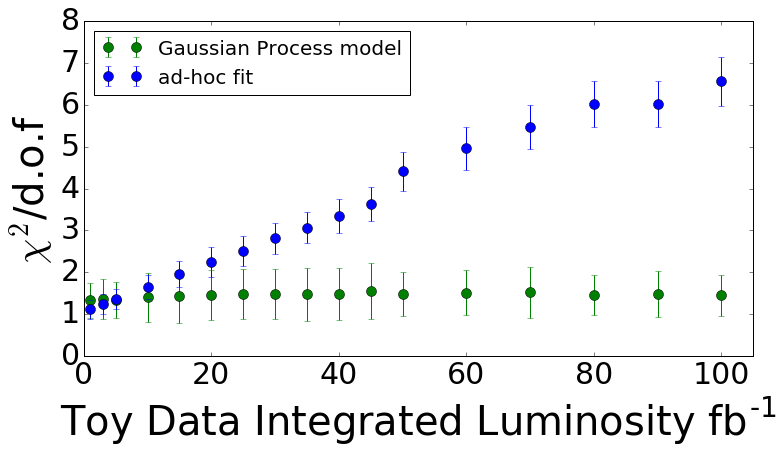

In [21]:
#lumiList =  [1.,3.,5.0, 10.0, 15.0, 20.0, 25., 30., 35., 40.,45., 50.,60., 70., 80., 90., 100.]
makePrettyPlots_chi2Lumi(lumiList, [GPchi2avList[i][0] for i in range(len(lumiList))], [FFchi2avList[i][0] for i in range(len(lumiList))], [GPchi2avList[i][1] for i in range(len(lumiList))], [FFchi2avList[i][1] for i in range(len(lumiList))], label)

print "done with toys, making plot"
label = "lumi vs chi2"
lumiList = [5.0, 10.0, 15.0, 20.0, 25., 30., 35., 40., 45., 50.]
GPchi2avList=[]
GPchi2avList_nofit=[]
FFchi2avList=[]
for lum in lumiList:
    print "LUM", lum

    print GPtotlist_cov[lum]
    chi2GPListp = [s for s in np.array(GPtotlist_cov[lum]) if s < 200] 
    chi2GPListp_nofit = [s for s in np.array(GPtotlist_nofit_cov[lum]) if s < 200] 
    chi2FFListp = [s for s in np.array(FFtotlist[lum]) if s < 200]

    print "GP avg", np.mean(np.array(chi2GPListp)), np.std(np.array(chi2GPListp)/np.sqrt(len(chi2GPListp)))
    print "GP avg no fit", np.mean(np.array(chi2GPListp_nofit)), np.std(np.array(chi2GPListp_nofit)/np.sqrt(len(chi2GPListp_nofit)))
    print "FF avg", np.mean(np.array(chi2FFListp)), np.std(np.array(chi2FFListp)/np.sqrt(len(chi2FFListp)))
    GPchi2avList.append([np.mean(np.array(chi2GPListp)), np.std(np.array(chi2GPListp))/np.sqrt(len(chi2GPListp))])
    GPchi2avList_nofit.append([np.mean(np.array(chi2GPListp_nofit)), np.std(np.array(chi2GPListp_nofit))/np.sqrt(len(chi2GPListp_nofit))])
    FFchi2avList.append([np.mean(np.array(chi2FFListp)), np.std(np.array(chi2FFListp))/np.sqrt(len(chi2FFListp))])
makePrettyPlots_chi2Lumi(lumiList, [GPchi2avList[i][0] for i in range(len(lumiList))], [FFchi2avList[i][0] for i in range(len(lumiList))], [GPchi2avList[i][1] for i in range(len(lumiList))], [FFchi2avList[i][1] for i in range(len(lumiList))], label)
makePrettyPlots_chi2Lumi(lumiList, [GPchi2avList_nofit[i][0] for i in range(len(lumiList))], [FFchi2avList[i][0] for i in range(len(lumiList))], [GPchi2avList_nofit[i][1] for i in range(len(lumiList))], [FFchi2avList[i][1] for i in range(len(lumiList))], label)